# Visualizing images with V and P

To view how the network makes its predictions, we need to see how predictions are made along both V and P

In [2]:
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import xarray as xr
from plot import plot_imageset

from time import perf_counter_ns

from image_data_helpers import minmax_label

mlp_path = Path('/Users/jarl/2d-discharge-nn/created_models/conditional_autoencoder/64x64/A64j/A64j')
ae_path = Path('/Users/jarl/2d-discharge-nn/created_models/autoencoder/64x64/A64-8/A64-8')

In [3]:
# import models
from autoencoder_classes import A64_8
from mlp_classes import MLP4

encodedx = 40
encodedy = encodedz = 8
encoding_size = encodedx*encodedy*encodedz

device = torch.device('mps')

imageMLP = MLP4(2, encoding_size, dropout_prob=0.5).to(device)
imageAE  = A64_8().to(device)

imageMLP.load_state_dict(torch.load(mlp_path))
imageAE.load_state_dict(torch.load(ae_path))

imageMLP.eval()
imageAE.eval()

A64_8(
  (encoder): Sequential(
    (0): Conv2d(5, 10, kernel_size=(9, 9), stride=(2, 2), padding=(4, 4))
    (1): ReLU()
    (2): Conv2d(10, 20, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): ReLU()
    (4): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
    (1): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
    (4): Conv2d(40, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): UpsamplingBilinear2d(scale_factor=2.0, mode=bilinear)
    (7): Conv2d(20, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): Conv2d(10, 5, kernel_size=(1, 1), stride=(1, 1))
    (10): ReLU()
  )
)

In [4]:
def get_prediction(v:float, p:float, variable='all'):
    # scale v, p
    label = torch.tensor(minmax_label(v, p), device=device, dtype=torch.float32)

    with torch.no_grad():
        fake_encoding = imageMLP(label,)  # mps does not support float64
        fake_encoding = fake_encoding.reshape(1, encodedx, encodedy, encodedz)
        decoded = imageAE.decoder(fake_encoding).cpu().numpy()[:, :, :64, :64]  # [batch, channel, height, width]

    if variable != 'all':
        return decoded[:, variable]

    return decoded

In [5]:
start = perf_counter_ns()
test = get_prediction(300.0, 60.0)
end = perf_counter_ns()

print(f'prediction made in {(end-start) * 1e-6} ms')

prediction made in 966.831458 ms


In [6]:
plot_imageset(test, 300, 60)

<Figure size 2100x600 with 10 Axes>

In [7]:
predictions = [get_prediction(v, p) for v in range(200, 400, 50) for p in range(20, 60, 5)]

In [8]:
import numpy as np
along_v = [get_prediction(v, 60) for v in range(200, 550, 50)]
vtest = np.concatenate(along_v, axis=0)

In [9]:
print(along_v[0].shape)
print(vtest.shape)

(1, 5, 64, 64)
(7, 5, 64, 64)


In [10]:
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import ImageGrid
from plot import draw_apparatus

def plot_along(images, value_range:range, cmap='viridis', out_dir=None, vp='V'):
    """
    Plot a set of images for each plasma parameter.

    Based on sep_test_comparison code.
    """
    # if is_square:
    extent = [0, 20, 35, 55]
    columns_math = ['$\phi$', '$n_e$', '$n_i$', '$n_m$', '$T_e$']

    fig = plt.figure(figsize=(7,4), dpi=300, layout='constrained')

    # create imagegrid for the original images (trugrid) and predicted ones (prdgrid)
    grid = ImageGrid(fig, 111, nrows_ncols=(5, images.shape[0]), direction='column', axes_pad=0.0, 
                     label_mode="L", share_all=True, cbar_location="right", cbar_mode="single", 
                     cbar_size="5%", cbar_pad='5%')
    
    # cbar_ranges = [(0, images[0, i].max()) for i in range(5)]  # shape: (5, 2)
    p90 = np.percentile(images, 95)
    cbar_ranges = [(0, images[:, i].max()) for i in range(5)]  # shape: (5, 2)
    v_list = list(value_range)

    idx = -1
    for j, ax in enumerate(grid):
        i = j % 5
        if i == 0:
            idx += 1

        org = ax.imshow(images[idx, i, :, :], origin='lower', extent=extent, aspect='equal',
                        vmin=0, vmax=cbar_ranges[i][1], cmap=cmap)
        draw_apparatus(ax)
        ax.set_ylabel(columns_math[i], fontsize=8, rotation=90)
        ax.set_xlabel(f'{v_list[idx]} {vp}', fontsize=8)
        cb = grid.cbar_axes[i].colorbar(org)
        cb.ax.tick_params(labelsize=6)

        ax.tick_params(axis='both', which='both', left=False, bottom=False, labelbottom=False,
        labelleft=False)

    return fig

In [11]:
plot_along(vtest, range(200, 550, 50))

<Figure size 2100x1200 with 70 Axes>

In [12]:
along_p = [get_prediction(300, p) for p in range(10, 70, 10)]
ptest = np.concatenate(along_p, axis=0)
ptest.shape

(6, 5, 64, 64)

In [13]:
plot_along(ptest, range(10, 70, 10), vp='Pa')

<Figure size 2100x1200 with 60 Axes>

In [14]:
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import ImageGrid
from plot import draw_apparatus

def plot_alongv2(images, value_range:range, cmap='viridis', out_dir=None, unit='V'):
    """
    Plot a set of images for each plasma parameter.

    Based on sep_test_comparison code.
    """
    # if is_square:
    extent = [0, 20, 35, 55]
    columns_math = ['$\phi$', '$n_e$', '$n_i$', '$n_m$', '$T_e$']

    fig = plt.figure(figsize=(7,4), dpi=300, layout='constrained')

    # create imagegrid for the original images (trugrid) and predicted ones (prdgrid)
    phi_grid = ImageGrid(fig, 511, nrows_ncols=(1, images.shape[0]), axes_pad=0.0, 
                     label_mode="L", share_all=True, cbar_location="right", cbar_mode="single", 
                     cbar_size="5%", cbar_pad='5%')
    
    ne_grid = ImageGrid(fig, 512, nrows_ncols=(1, images.shape[0]), axes_pad=0.0, 
                     label_mode="L", share_all=True, cbar_location="right", cbar_mode="single", 
                     cbar_size="5%", cbar_pad='5%')
    
    ni_grid = ImageGrid(fig, 513, nrows_ncols=(1, images.shape[0]), axes_pad=0.0, 
                     label_mode="L", share_all=True, cbar_location="right", cbar_mode="single", 
                     cbar_size="5%", cbar_pad='5%')
    
    nm_grid = ImageGrid(fig, 514, nrows_ncols=(1, images.shape[0]), axes_pad=0.0, 
                     label_mode="L", share_all=True, cbar_location="right", cbar_mode="single", 
                     cbar_size="5%", cbar_pad='5%')
    
    te_grid = ImageGrid(fig, 515, nrows_ncols=(1, images.shape[0]), axes_pad=0.0, 
                     label_mode="L", share_all=True, cbar_location="right", cbar_mode="single", 
                     cbar_size="7%", cbar_pad='8%')
    
    grids = [phi_grid, ne_grid, ni_grid, nm_grid, te_grid]
    
    # cbar_ranges = [(0, images[0, i].max()) for i in range(5)]  # shape: (5, 2)
    cbar_ranges = [(0, images[:, i].max()) for i in range(5)]  # shape: (5, 2)
    v_list = list(value_range)

    for i, grid in enumerate(grids):  # there are 5 grids, one for each param
        for j, ax in enumerate(grid):  # each param has n axes (images)
            im = ax.imshow(images[j, i, :, :], origin='lower', extent=extent, aspect='equal',
                            vmin=0, vmax=cbar_ranges[i][1], cmap=cmap)
            
            draw_apparatus(ax)

            ax.set_ylabel(columns_math[i], fontsize=8, rotation=90)

            if i == 4:  # label only the bottom
                ax.set_xlabel(f'{v_list[j]} {unit}', fontsize=8)

            cb = grid.cbar_axes[j].colorbar(im)
            cb.ax.tick_params(labelsize=6)
            ax.tick_params(axis='both', which='both', left=False, bottom=False, labelbottom=False,
                           
            labelleft=False)

    return fig

In [15]:
p_range = range(40, 85, 5)
along_p = [get_prediction(300, p) for p in p_range]
ptest = np.concatenate(along_p, axis=0)
ptest.shape

(9, 5, 64, 64)

In [16]:
plot_alongv2(ptest, p_range, unit='Pa')

<Figure size 2100x1200 with 90 Axes>

In [17]:
v_range = range(200, 600, 50)
along_v = [get_prediction(v, 60) for v in v_range]
vtest = np.concatenate(along_v, axis=0)
vtest.shape

(8, 5, 64, 64)

In [18]:
plot_alongv2(vtest, v_range)

<Figure size 2100x1200 with 80 Axes>

We need to get data along both V and P. By getting predictions along V first, we get a tensor with shape `[v, p, channels, height, width]`

In [19]:
graph_data = np.stack([np.concatenate([get_prediction(v, p) for p in p_range]) for v in v_range])
graph_data.shape

(8, 9, 5, 64, 64)

For a single variable, we need an `ImageGrid` that shows the variation of a single parameter across both V and P

In [20]:
def plot_variable(images, column:int, v_range:range, p_range:range, cmap='viridis', out_dir=None):
    """
    Plot a set of images for each plasma parameter.

    Based on sep_test_comparison code.
    """
    # if is_square:
    extent = [0, 20, 35, 55]
    columns = ['phi', 'ne', 'ni', 'nm', 'te']

    fig = plt.figure(figsize=(7,7), dpi=300, layout='constrained')

    # grid goes along p horizontally and v vertically
    grid = ImageGrid(fig, 111, nrows_ncols=(images.shape[0], images.shape[1]), axes_pad=0.0, 
                     label_mode="L", share_all=True, cbar_location="right", cbar_mode="single", 
                     cbar_size="3%", cbar_pad='3%')
    
    # cbar_ranges = [(0, images[0, i].max()) for i in range(5)]  # shape: (5, 2)
    cbar_ranges = [(0, images.max()) for i in range(5)]  # shape: (5, 2)
    v_list = list(v_range)
    p_list = list(p_range)
    j = -1

    ijgrid = np.reshape(grid, (images.shape[0], images.shape[1]))  # grid is a flat array of Axes that we reshape to easily use i, j
    
    for i in range(images.shape[0]):  # for voltage in voltages
        for j in range(images.shape[1]):  # for pressure in pressures
            k = images.shape[0]-i-1     # reverse the indexing of i such that the images are generated starting from the lower left
                                        # this makes it such that the (0, 0)th image corresponds to the highest voltage and the lowest pressure
            ax = ijgrid[i, j]  # axes where image is plotted is on the (i, j)th point of the grid
            
            # plot the ith voltage and the jth pressure
            im = ax.imshow(images[k, j, column], origin='lower', extent=extent, aspect='equal',
                        vmin=0, vmax=images[:,:,column].max(), cmap=cmap)
            
            draw_apparatus(ax)
            ax.set_xlabel(f'{p_list[j]} Pa', fontsize=8)  # jth pressure
            ax.set_ylabel(f'{v_list[k]} V' , fontsize=8, rotation=90)  # ith voltage

            cb = grid.cbar_axes[j].colorbar(im)
            cb.ax.tick_params(labelsize=8)
            ax.tick_params(axis='both', which='both', left=False, bottom=False, labelbottom=False,
            labelleft=False)
        
    if out_dir is not None:
        fig.savefig(out_dir/f'{columns[column]}.png', bbox_inches='tight')


In [21]:
plot_variable(graph_data, 0, v_range, p_range)

Here we make this plot for all variables (columns) and saving them to a specified file.

In [22]:
# out_dir = Path('/Users/jarl/2d-discharge-nn/pca')
# for column in range(0,5):
#     plot_variable(graph_data, column, v_range, p_range, out_dir=out_dir)

To do:
1. check the scales of the data across the entire dataset range

To make things simpler, it might be better to combine everything into one class.

In [23]:
class ImagePrediction:
    def __init__(self, v_range, p_range):
        self.v_range = v_range
        self.p_range = p_range
        self.columns =  ['phi', 'ne', 'ni', 'nm', 'te']
        self.columns_full =  ['Electric potential', 'Electron density', 'Ion density', 
                'Metastable density', 'Electron temperature']
        self.units = ['V', 'cm-3', 'cm-3', 'cm-3', 'eV']
        self.ds = self.dataset_init()

    
    def _create_da(self, index:int, v_range:range=range(200, 550, 50), p_range:range=range(5, 125, 10)):
        
        x_range = np.linspace(0, 200, 64)
        y_range = np.linspace(350, 500, 64)

        da = xr.DataArray([np.concatenate([get_prediction(v, p, index) for p in p_range]) for v in v_range],
                        dims=["V", "P", "x", "y"],
                        coords=dict(V=v_range, P=p_range, x=x_range, y=y_range),
                        attrs=dict(description=self.columns_full[index], units=self.units[index]),
                        name=self.columns[index]
        )

        return da


    def dataset_init(self):
        ds = xr.merge([self._create_da(i, self.v_range, self.p_range) for i in range(5)], combine_attrs="drop")
    
        return ds.assign_attrs(dict(description='Plasma image predictions by ImageMLP version A64j'))
    
    
    def plot_variable(self, variable, cmap='viridis', out_dir=None):
        """
        Plot a set of images for a specific plasma parameter.

        This plot shows how the images change across both V and P. Based on sep_test_comparison code.
        """

        ds = self.ds
        # if is_square:
        extent = [0, 20, 35, 55]
        columns = ['phi', 'ne', 'ni', 'nm', 'te']
        num_V = len(ds.V)
        num_P = len(ds.P)

        fig = plt.figure(figsize=(7,7), dpi=300, layout='constrained')

        # grid goes along p horizontally and v vertically
        grid = ImageGrid(fig, 111, nrows_ncols=(num_V, num_P), axes_pad=0.0, 
                        label_mode="L", share_all=True, cbar_location="right", cbar_mode="single", 
                        cbar_size="3%", cbar_pad='3%')
        
        # cbar_ranges = [(0, images[0, i].max()) for i in range(5)]  # shape: (5, 2)
        v_list = list(ds.V.values)
        p_list = list(ds.P.values)
        j = -1

        ijgrid = np.reshape(grid, (num_V, num_P))  # grid is a flat array of Axes that we reshape to easily use i, j
        
        for i, voltage in enumerate(reversed(v_list)):  # for voltage in voltages (reversed)
            for j, pressure in enumerate(p_list):  # for pressure in pressures
                ax = ijgrid[i, j]  # axes where image is plotted is on the (i, j)th point of the grid
                
                # plot the ith voltage and the jth pressure
                im = ax.imshow(ds[variable].sel(V=voltage, P=pressure), origin='lower', extent=extent, aspect='equal',
                            vmin=0, vmax=ds[variable].max(), cmap=cmap)
                
                draw_apparatus(ax)
                ax.set_xlabel(f'{pressure} Pa', fontsize=8)  # jth pressure
                ax.set_ylabel(f'{voltage} V' , fontsize=8, rotation=90)  # ith voltage

                cb = grid.cbar_axes[j].colorbar(im)
                cb.ax.tick_params(labelsize=8)
                ax.tick_params(axis='both', which='both', left=False, bottom=False, labelbottom=False,
                labelleft=False)

        if out_dir is not None:
            fig.savefig(out_dir/f'{variable}.png', bbox_inches='tight')

        return fig
    

In [24]:
v_range=range(200, 550, 50)
p_range=range(5, 125, 10)
prediction = ImagePrediction(v_range, p_range)
ds = prediction.ds
ds

<xarray.Dataset>
Dimensions:  (V: 7, P: 12, x: 64, y: 64)
Coordinates:
  * V        (V) int64 200 250 300 350 400 450 500
  * P        (P) int64 5 15 25 35 45 55 65 75 85 95 105 115
  * x        (x) float64 0.0 3.175 6.349 9.524 12.7 ... 190.5 193.7 196.8 200.0
  * y        (y) float64 350.0 352.4 354.8 357.1 ... 492.9 495.2 497.6 500.0
Data variables:
    phi      (V, P, x, y) float32 0.0 0.0 0.0 0.0 ... 0.6661 0.6107 0.515 0.1713
    ne       (V, P, x, y) float32 0.0 0.0 0.0 0.0 ... 0.01713 0.008433 0.0 0.0
    ni       (V, P, x, y) float32 0.0 0.0 0.0 0.0 ... 0.01228 0.001723 0.01858
    nm       (V, P, x, y) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    te       (V, P, x, y) float32 0.0 0.0 0.0 0.0 ... 0.2825 0.25 0.2064 0.114
Attributes:
    description:  Plasma image predictions by ImageMLP version A64j

In [25]:
# save a plot for all variables
# [prediction.plot_variable(variable, out_dir=Path('/Users/jarl/2d-discharge-nn/pca')) for variable in list(ds.data_vars)]

To perform PCA, we need to get a set of model predictions along one input (e.g. P) and convert an image into an input (feature) vector.

Choosing a fixed voltage $V=300$,

In [26]:
pca_test = ds['phi'].sel(V=300)
pca_test

<xarray.DataArray 'phi' (P: 12, x: 64, y: 64)>
array([[[0.        , 0.        , 0.        , ..., 0.41662443,
         0.31386983, 0.12642205],
        [0.        , 0.        , 0.        , ..., 0.40883672,
         0.2950025 , 0.10611336],
        [0.        , 0.        , 0.        , ..., 0.39821935,
         0.281913  , 0.13282311],
        ...,
        [0.5566878 , 0.560298  , 0.55506945, ..., 0.37423533,
         0.2617723 , 0.10646617],
        [0.53914195, 0.55991864, 0.55655146, ..., 0.36867487,
         0.26123634, 0.10758206],
        [0.520297  , 0.5574389 , 0.5657735 , ..., 0.37510252,
         0.29036856, 0.14280409]],

       [[0.        , 0.        , 0.        , ..., 0.42041147,
         0.33195522, 0.13942996],
        [0.        , 0.        , 0.        , ..., 0.4245817 ,
         0.32758743, 0.11448434],
        [0.        , 0.        , 0.        , ..., 0.4094042 ,
         0.3058986 , 0.13958137],
...
        [0.35315815, 0.3589873 , 0.3634362 , ..., 0.24704915,
         0.18513682, 0.06541626],
        [0.3522276 , 0.3575963 , 0.3610842 , ..., 0.21156754,
         0.14995205, 0.04768094],
        [0.3527523 , 0.3588364 , 0.3601687 , ..., 0.22949071,
         0.14658341, 0.0524113 ]],

       [[0.        , 0.        , 0.        , ..., 0.31485605,
         0.26663965, 0.10375165],
        [0.        , 0.        , 0.        , ..., 0.33193704,
         0.2841404 , 0.13695586],
        [0.        , 0.        , 0.        , ..., 0.31853947,
         0.25963342, 0.13967812],
        ...,
        [0.327774  , 0.33320212, 0.33673453, ..., 0.22421242,
         0.16458975, 0.05687872],
        [0.32831097, 0.33374998, 0.3354351 , ..., 0.19045837,
         0.13191217, 0.040604  ],
        [0.33614653, 0.34005898, 0.3398471 , ..., 0.21045125,
         0.13230193, 0.05068101]]], dtype=float32)
Coordinates:
    V        int64 300
  * P        (P) int64 5 15 25 35 45 55 65 75 85 95 105 115
  * x        (x) float64 0.0 3.175 6.349 9.524 12.7 ... 190.5 193.7 196.8 200.0
  * y        (y) float64 350.0 352.4 354.8 357.1 ... 492.9 495.2 497.6 500.0

In [27]:
pca_test.values.shape

(12, 64, 64)

Now these images need to be converted into a single dimensional vector, and then standardized to a mean $\mu = 0$ and variance $\sigma= 1$

In [28]:
pca_test.values.reshape(pca_test.values.shape[0], 4096).shape

(12, 4096)

In [29]:
X = pca_test.values.reshape(pca_test.values.shape[0], 4096)
X = (X-X.mean())/X.std()

When performing the actual PCA, we choose 2 components to get a 2D scatter plot of the input images.

In [30]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

In [31]:
print(pca.explained_variance_ratio_)

[0.9706975  0.02657739]


This means that the first and second components explain 97% and 2.6% of the variance, respectively.

In [32]:
print(pca.singular_values_)

[57.911922  9.582574]


I'm not sure what this means...

Now we get the coordinates of each image when projected along the first two principal components:

In [33]:
transformed = pca.transform(X)

In [34]:
transformed

array([[ 29.812744  ,   5.954329  ],
       [ 21.502941  ,   2.1301377 ],
       [ 16.210602  ,  -2.648286  ],
       [ 11.650815  ,  -3.0811312 ],
       [  6.436179  ,  -3.2830708 ],
       [  1.6620548 ,  -3.018926  ],
       [ -4.817379  ,  -1.5413998 ],
       [ -8.772519  ,  -0.48951513],
       [-11.910208  ,   0.2309106 ],
       [-16.20343   ,   1.0568631 ],
       [-19.87549   ,   1.7746568 ],
       [-25.696312  ,   2.9154327 ]], dtype=float32)

Text(0.5, 1.0, 'Voltage = 300 V')

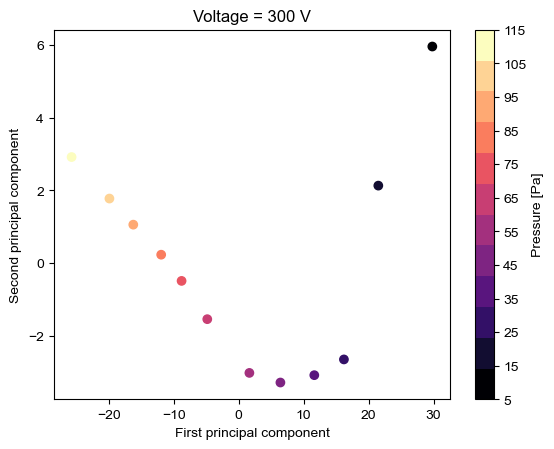

In [35]:
%matplotlib inline
from matplotlib import cm

cmap = cm.get_cmap('magma', len(p_range))
norm = cm.colors.Normalize(vmax=max(p_range), vmin=min(p_range))

fig, ax = plt.subplots()
sc = ax.scatter(transformed[:, 0], transformed[:, 1], c=p_range, cmap=cmap, norm=norm)
cb = plt.colorbar(sc, spacing='proportional')
cb.set_label('Pressure [Pa]')
cb.set_ticks(p_range)

ax.set_xlabel('First principal component')
ax.set_ylabel('Second principal component')
ax.set_title('Voltage = 300 V')

In [36]:
fig.savefig('300V_pca.png', dpi=300, bbox_inches='tight')

We can plot the contribution of each of the input features (pixels) to the first principal component:

In [37]:
pca.components_.shape

(2, 4096)

In [38]:
comps = pca.components_

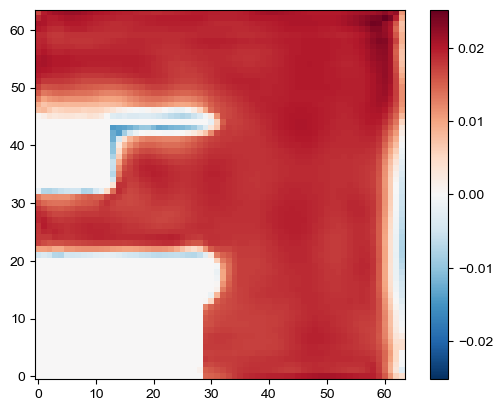

In [39]:
fig, ax = plt.subplots()
heatmap = ax.imshow(comps[0].reshape(64, 64), origin='lower', cmap='RdBu_r',
                   vmin=-comps[0].max(), vmax=comps[0].max())
cb = plt.colorbar(heatmap)
fig.savefig('pca_1.png')

In [40]:
Xorg = pca_test.values.reshape(pca_test.values.shape[0], 4096)

In [42]:
Xorg.mean()

0.35638642

In [43]:
pca.get_covariance().shape

(4096, 4096)

Now, let's try to do the PCA analysis across the entire ranges of V and P

In [59]:
def pca(prediction:ImagePrediction, which='p'):
    """
    prediction: ImagePrediction
    which: 'p' along pressure or 'v' along voltage
    """
    v_range = prediction.v_range
    p_range = prediction.p_range
    ds = prediction.ds
        
    def pca_transform(pv):
        # slice to get the data
        if which == 'p':
            xdata = ds['phi'].sel(V=pv)
        elif which == 'v':
            xdata = ds['phi'].sel(P=pv)
        
        X = xdata.values.reshape(xdata.values.shape[0], 4096)
        X = (X-X.mean())/X.std()
        
        pca = PCA(n_components=2)
        pca.fit(X)
        
        # variance_ratio = pca.explained_variance_ratio_
        
        return pca.transform(X)
    
    if which == 'p':
        return np.stack([pca_transform(v) for v in v_range])
    elif which == 'v':
        return np.stack([pca_transform(p) for p in p_range]) 

In [60]:
pcadata = pca(prediction)

In [61]:
pcadata.shape

(7, 12, 2)

In [72]:
def pca_plot(data, which='p'):
    
    if which == 'p':
        varrange = p_range
        label = 'Pressure [Pa]'
        
    elif which == 'v':
        varrange = v_range
        label = 'Voltage [V]'
        
    
    cmap = cm.get_cmap('magma', len(varrange))
    norm = cm.colors.Normalize(vmax=max(varrange), vmin=min(varrange))

    fig, ax = plt.subplots()

    for var in range(data.shape[0]):
        sc = ax.scatter(data[var, :, 0], data[var, :, 1], c=varrange, cmap=cmap, norm=norm)
    
    cb = plt.colorbar(sc, spacing='proportional')
    cb.set_label(label)
    cb.set_ticks(varrange)
    
    ax.set_xlabel('First principal component')
    ax.set_ylabel('Second principal component')

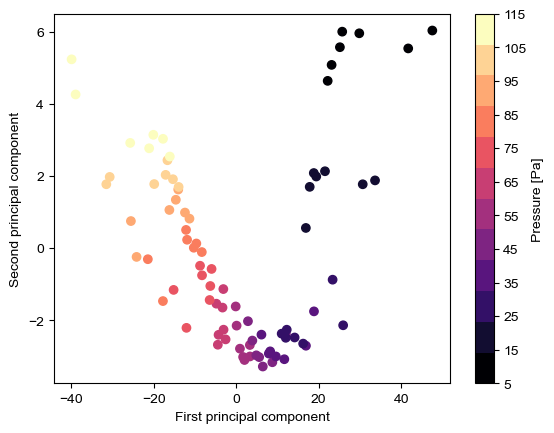

In [63]:
%matplotlib inline
pca_plot(pcadata)

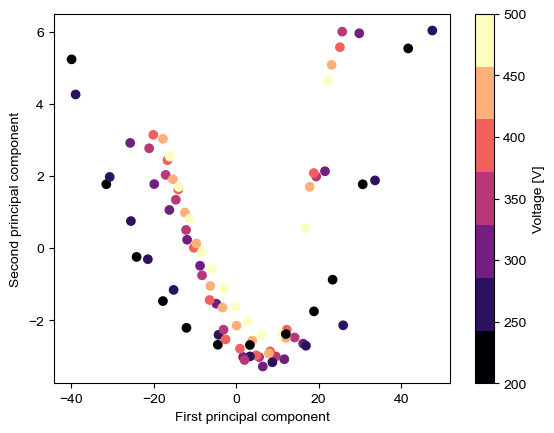

In [64]:
pca_plot(pcadata, which='v')

In [71]:
pcadata_v = pca(prediction, 'v')
pcadata_v.shape

(12, 7, 2)

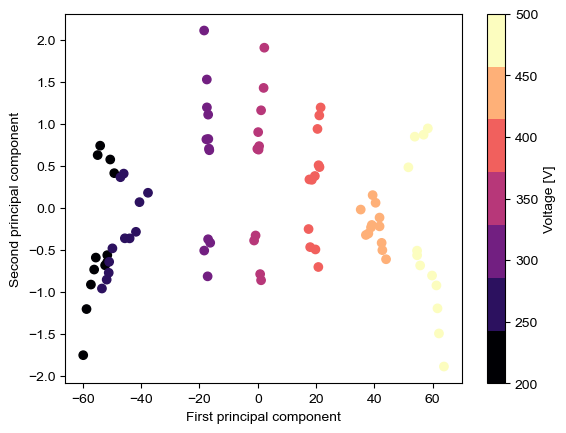

In [73]:
pca_plot(pcadata_v, 'v')